In [50]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
from pdb import set_trace
from datetime import datetime

#plt.style.use('seaborn-pastel')
#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
#plt.style.use('ggplot')
#plt.style.use('seaborn')
#plt.style.use('seaborn-paper')

%matplotlib inline

In [14]:
df = pd.read_csv("../experiments/experiments.csv",index_col=0)

In [15]:
df[(df['perf']==True) & (pd.isna(df['n_ep']))]

,folder,tag,env,n,save_interval,train_steps,not_save,env_config,env_num,description,weights,n_steps,gamma,perf,n_ep,hours
119,NaN,TLeft_perf_126,Turn_left_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,experiments/111_Turn_left_v2.1/weights_1260100...,NaN,NaN,True,NaN,NaN
120,NaN,TLeft_perf_108,Turn_left_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,experiments/111_Turn_left_v2.1/weights_1080091...,NaN,NaN,True,NaN,NaN
121,NaN,TLeft_perf,Turn_left_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hrl/weights/Turn_left/v1.2_exp84_weights_final...,NaN,NaN,True,NaN,NaN
122,NaN,TRight_perf,Turn_right_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hrl/weights/Turn_right/v1.2_exp85_weights_fina...,NaN,NaN,True,NaN,NaN
123,NaN,TRight_perf_126,Turn_right_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,experiments/112_Turn_right_v2.1/weights_126010...,NaN,NaN,True,NaN,NaN
124,NaN,TRight_perf_117,Turn_right_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,experiments/112_Turn_right_v2.1/weights_117009...,NaN,NaN,True,NaN,NaN
131,NaN,CRight_perf_2.4m,Change_to_right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,experiments/115_CRight_1.3/weights_2402304.pkl,NaN,NaN,True,NaN,NaN
132,NaN,CRight_perf_3.3m,Change_to_right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,experiments/115_CRight_1.3/weights_3303168.pkl,NaN,NaN,True,NaN,NaN
133,NaN,CRight_perf_pol,Change_to_right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hrl/weights/CRight/v1.1_exp109_weights_final.pkl,NaN,NaN,True,NaN,NaN
138,NaN,CLeft_perf_127_final,Change_to_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,experiments/127_CLeft_1.3/weights_final.pkl,NaN,NaN,True,NaN,NaN


In [16]:
failed = []
scalars_from_tb = set()
scalars = ['episode/episode_reward','episode_reward/episode_reward','episode_reward']
if 'hours' not in df.columns: df['hours'] = np.nan
for index, row in df.iterrows():
    #if index == 3: set_trace()
    if (row['perf'] == False and 'memory' not in str(row['tag']) and pd.isna(row['hours'])) or (pd.isna(row['n_ep'])):
        try:
            if pd.isna(row['tag']) == False:
                if row['perf']:
                    logs = EventAccumulator('../experiments/' + str(index) + '_' + row['tag'] + '/logs/extra')
                else:
                    logs = EventAccumulator('../experiments/' + str(index) + '_' + row['tag'] + '/logs/PPO2_1')
            else:
                if row['perf']:
                    logs = EventAccumulator('../experiments/' + str(index) + '/logs/extra')
                else:
                    logs = EventAccumulator('../experiments/' + str(index) + '/logs/PPO2_1')    
            logs.Reload()

            [scalars_from_tb.add(s) for s in logs.Tags()['scalars']]
            
            for tag in scalars:
                if tag in logs.Tags()['scalars']:
                    wtime,_,_ = zip(*logs.Scalars(tag))
                    break
            if pd.isna(row['n_ep']):
                df.loc[index,'n_ep'] = len(wtime)
                            
            if row['perf'] is False and 'memory' not in str(row['tag']) and pd.isna(row['hours']):
                hours = (datetime.fromtimestamp(wtime[-1])-datetime.fromtimestamp( wtime[0])).total_seconds()/60/60
                df.loc[index,'hours'] = hours
        except:
            failed.append(index)
        
        
    
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


113
114
115


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


137
138
139
140
141
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224


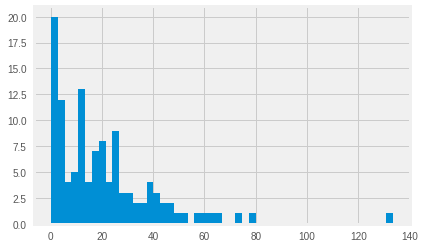

In [52]:
df.hours.hist(bins=50)

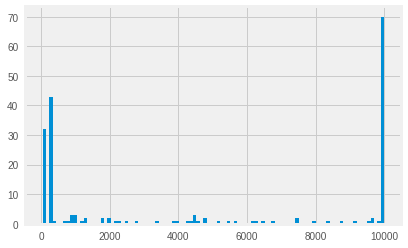

In [47]:
df.n_ep.hist(bins=100)

In [19]:
df.loc[pd.isna(df.n_ep) & (df.tag.str.contains("memory") == False)]

,folder,tag,env,n,save_interval,train_steps,not_save,env_config,env_num,description,weights,n_steps,gamma,perf,n_ep,hours
75,outside_experiments,Turn_c,Turn,0.0,4000.0,300000.0,0.0,"{'allow_reverse': False, 'grayscale': 1, 'show...",4.0,first run on the server,NaN,30.0,NaN,False,NaN,NaN


In [22]:
df.loc[pd.isna(df.hours) & (df.perf == False) & (df.tag.str.contains("memory") == False)]

,folder,tag,env,n,save_interval,train_steps,not_save,env_config,env_num,description,weights,n_steps,gamma,perf,n_ep,hours
75,outside_experiments,Turn_c,Turn,0.0,4000.0,300000.0,0.0,"{'allow_reverse': False, 'grayscale': 1, 'show...",4.0,first run on the server,NaN,30.0,NaN,False,NaN,NaN


In [26]:
df.to_csv("../experiments/experiments.csv")